[View in Colaboratory](https://colab.research.google.com/github/Masum06/gender_mining/blob/master/char_rnn_hsc_data.ipynb)

###Down From Mega

In [2]:
%%bash
git clone https://github.com/jeroenmeulenaar/python3-mega.git python3mega
cd python3mega
pip install -r requirements.txt

  Running setup.py bdist_wheel for URLObject: started
  Running setup.py bdist_wheel for URLObject: finished with status 'done'
  Stored in directory: /content/.cache/pip/wheels/fd/7e/18/ccb55ecc2834f945b769c1ff1df12ca5a14400ccfc58e3c515
  Running setup.py bdist_wheel for pycrypto: started
  Running setup.py bdist_wheel for pycrypto: finished with status 'done'
  Stored in directory: /content/.cache/pip/wheels/27/02/5e/77a69d0c16bb63c6ed32f5386f33a2809c94bd5414a2f6c196
Successfully built URLObject pycrypto


Cloning into 'python3mega'...


In [0]:
import os
os.chdir('python3mega')
from mega import Mega
m = Mega.from_ephemeral()
os.chdir('..')

In [0]:
m.download_from_url('https://mega.nz/#!RQgxjTDR!vrQimln7Yvtxgn6lqSmKWW1CAWFmSCM2JbWsQcT9ptA') # HSC Name dataset

In [1]:
!ls

datalab


# Character RNN

In [7]:
# https://keras.io/
!pip install -q keras
!pip install scikit-learn
!pip install matplotlib

In [0]:
%matplotlib inline
import itertools
import keras
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [0]:
import pandas as pd
import numpy as np
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, Bidirectional
from keras.layers import LSTM, GRU
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix

fileName = './hsc_name_gender.csv'

# Lowering the texts and replacing with numeral value
df = pd.read_csv(fileName, encoding='utf-8')
df.columns = ['name', 'gender']
df['name'] = df['name'].str.lower()

df = df.dropna()
df = df.drop_duplicates()

# Getting all available strings to find out the characters used
all_string = " ".join([name for name in df['name']])
unique_characters = list(set(list(all_string)))

# Mapping between character to index and index to character
char2idx = { c : i for i, c in enumerate(unique_characters) }
idx2char = {c: k for k, c in char2idx.items()}

# Converts a name into vector
def name2vector(name):
    chars = list(name)
    vector = [ char2idx[c] for c in chars ]
    return np.array(vector)

# Converts names to fixed size tensor
def names2tensor(names, maxlen=25):
    namelist = [name2vector(name) for name in names]
    return sequence.pad_sequences(np.array(namelist), maxlen=maxlen)  # root of all troubles

In [13]:
# train dataset
X = np.array(names2tensor(df['name'], maxlen=25)) #
Y = np.array([int(g) for g in df['gender']])

X, Y = shuffle(X, Y, random_state=42)

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3) #changed

# max features
max_features = 20000
batch_size = 32
epochs = 1

# Model building and training
print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(128, dropout=0.5, recurrent_dropout=0.5)) #changed
model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy']             
             )

filepath="weights-improvement-{epoch:02d}-{val_acc:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

Build model...
Train...
Train on 2121126 samples, validate on 909055 samples
Epoch 1/1
  17824/2121126 [..............................] - ETA: 1:32:07 - loss: 0.4723 - acc: 0.7631

2121120/2121126 [============================>.] - ETA: 0s - loss: 0.1172 - acc: 0.9570

2121126/2121126 [==============================] - 5911s 3ms/step - loss: 0.1172 - acc: 0.9570 - val_loss: 0.0765 - val_acc: 0.9745

Epoch 00001: val_acc improved from -inf to 0.97449, saving model to weights-improvement-01-0.97.hdf5


In [0]:
print('Train...')
model.fit(x_train, y_train,batch_size=batch_size, epochs=epochs, callbacks=callbacks_list, validation_data=(x_test, y_test))

Train...
Train on 2121126 samples, validate on 909055 samples
Epoch 1/1
  19488/2121126 [..............................] - ETA: 1:29:11 - loss: 0.0944 - acc: 0.9682

 287424/2121126 [===>..........................] - ETA: 1:18:14 - loss: 0.0916 - acc: 0.9681

In [0]:
i = 4
from keras.models import load_model

model.save('char_rnn_hsc_model_{}.h5'.format(i))

In [20]:
!curl --upload-file ./char_rnn_hsc_model_2.h5 https://transfer.sh/char_rnn_hsc_model_2.h5

https://transfer.sh/xvS43/char_rnn_hsc_model_2.h5

In [30]:
ls

char_rnn_hsc_model_1.h5  datalab/             python3mega/
char_rnn_hsc_model_2.h5  drive/               weights-improvement-01-0.97.hdf5
char_rnn_hsc_model_3.h5  hsc_name_gender.csv  weights-improvement-01-0.98.hdf5




*   https://transfer.sh/AqEf7/char_rnn_hsc_model_1.h5: 97.45
*   https://transfer.sh/xvS43/char_rnn_hsc_model_2.h5: 97.55
*   char_rnn_hsc_model_3.h5: 97.61



###Connect to drive, save the model

In [22]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
!cp char_rnn_hsc_model_4.h5 drive/deeper/data/char_rnn_hsc_models/

###Load model and run

In [0]:
!cp drive/deeper/data/char_rnn_hsc_models/char_rnn_hsc_model_3.h5 ./

In [0]:
model.load('char_rnn_hsc_model_3.h5')

###Dataframe

In [10]:
df.head

<bound method NDFrame.head of                       en_name  gender
0                  saju ahmed       1
1              md martuj  ali       1
2                rushna begum       0
3                nazira akter       0
4                    ali miah       1
5                 saira begum       0
6              khaled hossain       1
7              md jamal uddin       1
8                 rajna begum       0
9                shanta akter       0
10                ahsan uddin       1
11               latifa begum       0
12              sokhina begum       0
13                tajul islam       1
14               forida begum       0
15               ariful islam       1
16               azizul haque       1
17               fatema begum       0
18           md jakirul islam       1
19              md abu siddik       1
20               majeda begum       0
21               shuva  begum       0
22                badsha miah       1
23               hakima begum       0
24               azi

In [12]:
len(df.drop_duplicates())

3030181

In [13]:
len(df)

13565233

###Testing

In [0]:
# LOAD SAVED MODEL
from keras.models import load_model

#del model  # deletes the existing model
model = load_model('char_rnn_hsc_model.h5')

In [0]:
y_pred = np.array([y[0] for y in model.predict_classes(x_test)])

In [0]:
print(df['en_name'])

In [0]:
print(idx2char)

{0: 'c', 1: '(', 2: 's', 3: ')', 4: 'a', 5: 'n', 6: 'y', 7: 'g', 8: '.', 9: 'i', 10: 'd', 11: 'v', 12: 'm', 13: ':', 14: 'f', 15: '-', 16: 'x', 17: 'q', 18: 'o', 19: 'l', 20: 'e', 21: 'k', 22: 'z', 23: 'u', 24: 't', 25: 'p', 26: 'b', 27: ' ', 28: 'w', 29: 'r', 30: 'j', 31: 'h'}


In [0]:
X1 = np.array(names2tensor(df['en_name']))
print(names2tensor(df['en_name']))

[[ 0  0  0 ... 19  4 12]
 [ 0  0  0 ... 19  4 12]
 [ 0  0  0 ... 18 23  2]
 ...
 [ 0  0  0 ...  2  4  5]
 [ 0  0  0 ... 12  4  5]
 [ 0  0  0 ... 24 20 29]]


In [0]:
print(y_train.shape)
print(char2idx)
print(len(char2idx))
print(idx2char)
for i in range(10):
  for x in names2tensor(df['en_name'])[i]:
    print(idx2char[x], end="")
  print()

(26940,)
{'c': 0, '(': 1, 's': 2, ')': 3, 'a': 4, 'n': 5, 'y': 6, 'g': 7, '.': 8, 'i': 9, 'd': 10, 'v': 11, 'm': 12, ':': 13, 'f': 14, '-': 15, 'x': 16, 'q': 17, 'o': 18, 'l': 19, 'e': 20, 'k': 21, 'z': 22, 'u': 23, 't': 24, 'p': 25, 'b': 26, ' ': 27, 'w': 28, 'r': 29, 'j': 30, 'h': 31}
32
{0: 'c', 1: '(', 2: 's', 3: ')', 4: 'a', 5: 'n', 6: 'y', 7: 'g', 8: '.', 9: 'i', 10: 'd', 11: 'v', 12: 'm', 13: ':', 14: 'f', 15: '-', 16: 'x', 17: 'q', 18: 'o', 19: 'l', 20: 'e', 21: 'k', 22: 'z', 23: 'u', 24: 't', 25: 'p', 26: 'b', 27: ' ', 28: 'w', 29: 'r', 30: 'j', 31: 'h'}
cccccccccccccjubiada alam
cccccccccccccshamsul alam
cccccccccjannatul ferdous
ccccccccmd. shadman sakib
ccccccccccccccccmd. mamun
ccccccccccshahanur  begum
cccccca.k.m. abirul haque
cccca.k.m. ashraful haque
cccccccccccccsamsun nahar
ccccccccccccccmd. al-amin


In [0]:
#name = [idx2char[x] for x in x_train[1]]
#print(name)
#print(np.array(names2tensor(["masum"])))

def nameTest(name):
  result = model.predict_classes(np.array(names2tensor([name])))[0][0]
  if result:
    print("Male")
  else:
    print("Female")

In [0]:
#model.predict_classes(nameTest("masum"))
name = "shamim"
nameTest(name)

Female


Confusion matrix, without normalization
[[4996  122]
 [ 119 6310]]


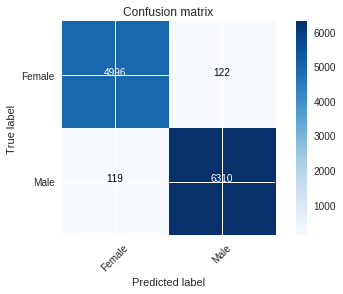

In [0]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred), classes=['Female', 'Male'], normalize=False)

In [0]:
y_train[y_train == 1.0].shape

(10703,)

# Named Entity Detection

# Polygot
http://polyglot.readthedocs.io/en/latest/NamedEntityRecognition.html
Failed to make it work.

In [0]:
!pip install polyglot

    100% |████████████████████████████████| 133kB 4.2MB/s 
  Running setup.py bdist_wheel for polyglot ... - \ done
  Stored in directory: /content/.cache/pip/wheels/b4/b7/34/e6fbb82ec71c0c9d7f1b26a038f00129acd99a6aa5e5b93f2d
Successfully built polyglot


In [0]:
!apt-get install python-numpy libicu-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libicu-dev is already the newest version (57.1-6ubuntu0.2).
libicu-dev set to manually installed.
Suggested packages:
  python-nose python-numpy-dbg python-numpy-doc
The following NEW packages will be installed:
  python-numpy
0 upgraded, 1 newly installed, 0 to remove and 0 not upgraded.
Need to get 1,885 kB of archives.
After this operation, 10.7 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu artful/main amd64 python-numpy amd64 1:1.12.1-3.1ubuntu4 [1,885 kB]
Fetched 1,885 kB in 1s (1,428 kB/s)
Selecting previously unselected package python-numpy.
(Reading database ... 16712 files and directories currently installed.)
Preparing to unpack .../python-numpy_1%3a1.12.1-3.1ubuntu4_amd64.deb ...
Unpacking python-numpy (1:1.12.1-3.1ubuntu4) ...
Setting up python-numpy (1:1.12.1-3.1ubuntu4) ...


In [0]:
!apt-get install libicu-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libicu-dev is already the newest version (57.1-6ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.


In [0]:
from polyglot.text import Text

ImportError: ignored

In [0]:
!pip install -U git+https://github.com/aboSamoor/polyglot.git@master

  Cloning https://github.com/aboSamoor/polyglot.git (to master) to /tmp/pip-s5fe_s9q-build
    100% |████████████████████████████████| 204kB 3.4MB/s 
Requirement already up-to-date: numpy>=1.6.1 in /usr/local/lib/python3.6/dist-packages (from polyglot==16.7.4)
    100% |████████████████████████████████| 14.3MB 94kB/s 
Requirement already up-to-date: six>=1.7.3 in /usr/local/lib/python3.6/dist-packages (from polyglot==16.7.4)
    100% |████████████████████████████████| 51kB 10.1MB/s 
  Running setup.py bdist_wheel for PyICU ... - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | done
  Stored in directory: /content/.cache/pip/wheels/74/ee/ee/d464eefe0e8cc56f170ea09097cfbc11fc3bdf19de42d93b17
  Running setup.py bdist_wheel for futures ... - \ done
  Stored in directory: /content/.cache/pip/wheels/ad/79/48/b32521764d59b16fd1bc0ffd5862f6d3bf770c7d73ea1fb12a
  Running setup.py bdist_wheel for morfessor ... - \ d

 / - \ | / done
  Stored in directory: /content/.cache/pip/wheels/f0/ed/93/4e70bc7622711cb867d8df5bb90ad3bc1bd5cc1659f2dc6c41
Successfully built PyICU futures morfessor pycld2
  Found existing installation: futures 3.0.5
    Uninstalling futures-3.0.5:
      Successfully uninstalled futures-3.0.5
  Found existing installation: wheel 0.30.0
    Uninstalling wheel-0.30.0:
      Successfully uninstalled wheel-0.30.0
  Found existing installation: polyglot 16.7.4
    Uninstalling polyglot-16.7.4:
      Successfully uninstalled polyglot-16.7.4
  Running setup.py install for polyglot ... - \ done


In [0]:
from polyglot.detect import Detector

In [0]:
!apt-get install libicu-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libicu-dev is already the newest version (57.1-6ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.


# NLTK

In [0]:
!python -m nltk.downloader all

/usr/lib/python3.6/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /content/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /content/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /content/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloading package brown to /content/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package brown_tei to
[nltk_data]    |     /content/nltk_data...
[nltk_data]    |   Unzipping corpora/brown_tei.zip.
[nltk_data]    | Downloading package cess_cat to /content

[nltk_data]    |   Unzipping corpora/kimmo.zip.
[nltk_data]    | Downloading package knbc to /content/nltk_data...
[nltk_data]    | Downloading package lin_thesaurus to
[nltk_data]    |     /content/nltk_data...
[nltk_data]    |   Unzipping corpora/lin_thesaurus.zip.
[nltk_data]    | Downloading package mac_morpho to
[nltk_data]    |     /content/nltk_data...
[nltk_data]    |   Unzipping corpora/mac_morpho.zip.
[nltk_data]    | Downloading package machado to /content/nltk_data...
[nltk_data]    | Downloading package masc_tagged to
[nltk_data]    |     /content/nltk_data...
[nltk_data]    | Downloading package moses_sample to
[nltk_data]    |     /content/nltk_data...
[nltk_data]    |   Unzipping models/moses_sample.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /content/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /content/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[

[nltk_data]    |   Unzipping corpora/state_union.zip.
[nltk_data]    | Downloading package stopwords to
[nltk_data]    |     /content/nltk_data...
[nltk_data]    |   Unzipping corpora/stopwords.zip.
[nltk_data]    | Downloading package subjectivity to
[nltk_data]    |     /content/nltk_data...
[nltk_data]    |   Unzipping corpora/subjectivity.zip.
[nltk_data]    | Downloading package swadesh to /content/nltk_data...
[nltk_data]    |   Unzipping corpora/swadesh.zip.
[nltk_data]    | Downloading package switchboard to
[nltk_data]    |     /content/nltk_data...
[nltk_data]    |   Unzipping corpora/switchboard.zip.
[nltk_data]    | Downloading package timit to /content/nltk_data...
[nltk_data]    |   Unzipping corpora/timit.zip.
[nltk_data]    | Downloading package toolbox to /content/nltk_data...
[nltk_data]    |   Unzipping corpora/toolbox.zip.
[nltk_data]    | Downloading package treebank to /content/nltk_data...
[nltk_data]    |   Unzipping corpora/treebank.zip.
[nltk_data]    | Downlo

[nltk_data]    |   Unzipping models/bllip_wsj_no_aux.zip.
[nltk_data]    | Downloading package word2vec_sample to
[nltk_data]    |     /content/nltk_data...
[nltk_data]    |   Unzipping models/word2vec_sample.zip.
[nltk_data]    | Downloading package panlex_swadesh to
[nltk_data]    |     /content/nltk_data...
[nltk_data]    | Downloading package mte_teip5 to
[nltk_data]    |     /content/nltk_data...
[nltk_data]    |   Unzipping corpora/mte_teip5.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /content/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package perluniprops to
[nltk_data]    |     /content/nltk_data...
[nltk_data]    |   Unzipping misc/perluniprops.zip.
[nltk_data]    | Downloading package nonbreaking_prefixes to
[nltk_data]    |     /content/nltk_data...
[nltk_data]    |   Unzipping corpora/nonbreaking_prefixes.zip.
[nltk_data]    | Downloading package vader_lexico

In [0]:
# PARTS OF SPEECH
from nltk import pos_tag, word_tokenize
pos_tag(word_tokenize("John and Smith are going to NY and Germany"))

[('John', 'NNP'),
 ('and', 'CC'),
 ('Smith', 'NNP'),
 ('are', 'VBP'),
 ('going', 'VBG'),
 ('to', 'TO'),
 ('NY', 'NNP'),
 ('and', 'CC'),
 ('Germany', 'NNP')]

In [0]:
# NAMED ENTITY TAGGER
import nltk
sentence = "john is my best friend"
tokens = nltk.word_tokenize(sentence)
tagged = nltk.pos_tag(tokens)
entities = nltk.chunk.ne_chunk(tagged)
print(entities)

(S john/NN is/VBZ my/PRP$ best/JJS friend/NN)


In [0]:
tree1 = nltk.Tree('NP', ['Alice'])
print(tree1)

(NP Alice)


In [0]:
# NER output as a list

import nltk

my_sent = "Masum and Masum is my friend"

parse_tree = nltk.ne_chunk(nltk.tag.pos_tag(my_sent.split()), binary=True)  # POS tagging before chunking!

named_entities = []

for t in parse_tree.subtrees():
    if t.label() == 'NE':
        #named_entities.append(t)
        named_entities.append(list(t))  # if you want to save a list of tagged words instead of a tree

print(named_entities)

[[('Masum', 'NNP')], [('Masum', 'NNP')]]


In [0]:
named_entities

# Stanford NER

In [0]:
from nltk.tag import StanfordNERTagger
from nltk.tokenize import word_tokenize

st = StanfordNERTagger('/usr/share/stanford-ner/classifiers/english.all.3class.distsim.crf.ser.gz',
					   '/usr/share/stanford-ner/stanford-ner.jar',
					   encoding='utf-8')

text = 'While in France, Christine Lagarde discussed short-term stimulus efforts in a recent interview with the Wall Street Journal.'

tokenized_text = word_tokenize(text)
classified_text = st.tag(tokenized_text)

print(classified_text)

# NEED JAVA TO RUN THIS.
# PREFER TO RUN IT ON MY PC

LookupError: ignored